<h1>Emotion Classification</h1>

<h2>CNN-BiLSTM GloVe</h2>

In [1]:
import re
import contractions

import tqdm


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet as wordnet

from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, classification_report, 
    precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint



In [2]:
def wordnet_pos_code(tag):
    '''Translation from nltk tags to Wordnet code'''
    if tag.startswith('NN'):
        return wordnet.NOUN
    elif tag.startswith('VB'):
        return wordnet.VERB
    elif tag.startswith('JJ'):
        return wordnet.ADJ
    elif tag.startswith('RB'):
        return wordnet.ADV
    else:
        return None


In [3]:
#Load and parse data

train_df = pd.read_csv('//Users//datdao//Downloads//archive//train.txt', sep=";", header=None, names=['text','emotion'])
test_df = pd.read_csv('//Users//datdao//Downloads//archive//test.txt', sep=";", header=None, names=['text','emotion'])
val_df = pd.read_csv('//Users//datdao//Downloads//archive//val.txt', sep=";", header=None, names=['text','emotion'])

In [4]:
#Checking null values

train_df.info()
print()
test_df.info()
print()
val_df.info()
print()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     16000 non-null  object
 1   emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB



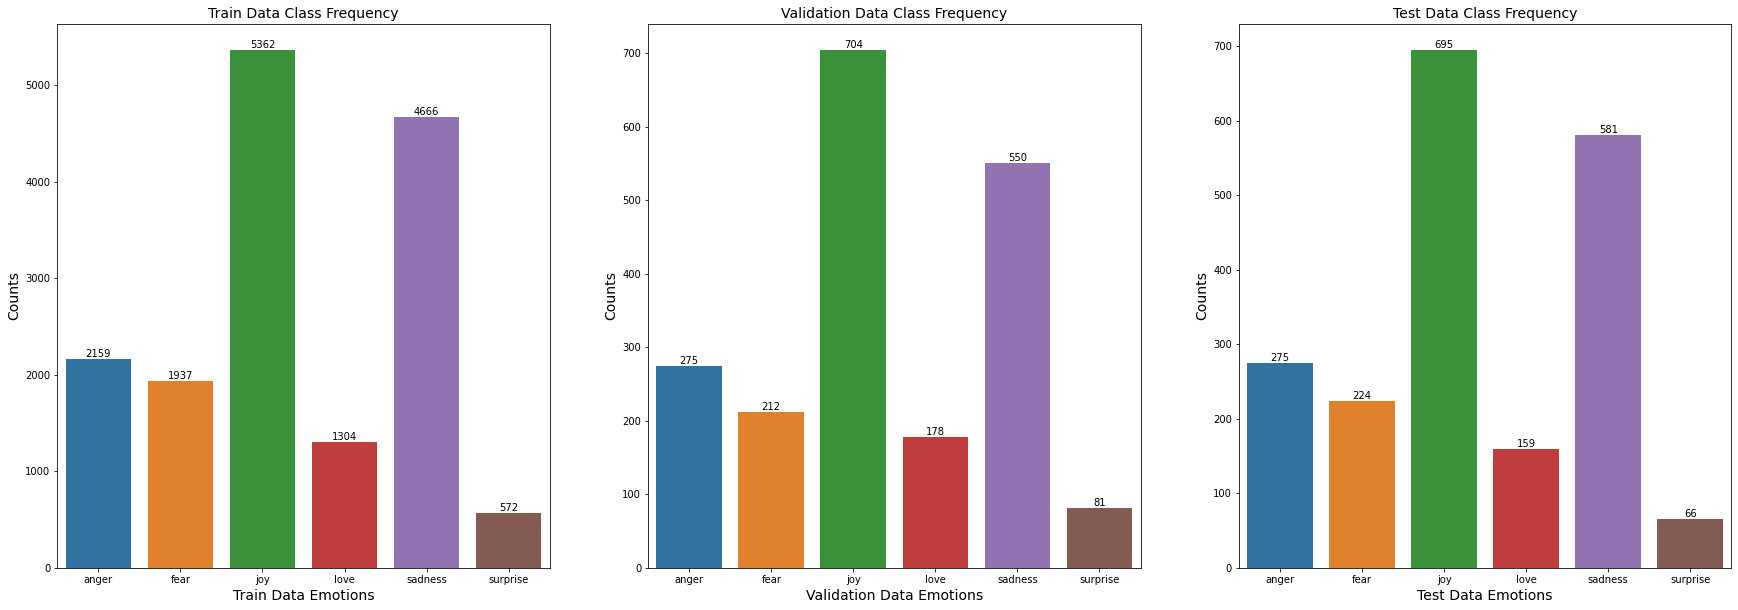

In [5]:
#Checking for distribution (data balance)

data = {'Train Data': train_df, 'Validation Data': val_df, 'Test Data': test_df}
bar, ax = plt.subplots(1,3, figsize=(30, 10))
emo_order = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

    
for index, datum in enumerate(data):
    sns.countplot(ax = ax[index],x = 'emotion', data = data[datum], order=emo_order)
    ax[index].set_title(datum +' Class Frequency', size=14)
    ax[index].set_ylabel('Counts', size=14)
    ax[index].set_xlabel(datum +' Emotions', size=14)
    ax[index].bar_label(ax[index].containers[0])
plt.show()




In [6]:
# Preprocessing: lower cases, remove non-text elements & stopwords, remove contractions, and tokenize data

lm = WordNetLemmatizer()

stoplist = ['feel', 'felt', 'feeling', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
            'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
            'she', 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
            'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is',
            'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
            'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
            'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below',
            'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
            'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
            'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will',
            'just', 'should', 'now', 'href',  'http', 'www', 'img', 'src',]


def data_prep(df):
    corpus = []
    for i in df:
        item = re.sub("[^a-zA-Z]"," ",str(i))
        item = contractions.fix(item)
        item = item.lower() 
        item = item.split()
        pos_tagging = pos_tag([i for i in item if i not in set(stoplist)])
        for word in pos_tagging:
            pos = wordnet_pos_code(word[1])
            if pos is not None:
                item = [lm.lemmatize(word, pos=pos) for word in item if word not in set(stoplist)]
        corpus.append(' '.join(str(x) for x in item))
    return corpus
        


def txt_tokenizer(df):
    tokens = word_tokenize(df)
    return tokens


In [7]:

train_df['text_prep'] = data_prep(train_df['text'])
test_df['text_prep'] = data_prep(test_df['text'])
val_df['text_prep'] = data_prep(val_df['text'])

train_df['token'] = train_df['text_prep'].apply(txt_tokenizer)
test_df['token'] = test_df['text_prep'].apply(txt_tokenizer)
val_df['token'] = val_df['text_prep'].apply(txt_tokenizer)

In [8]:
from sklearn.preprocessing import LabelEncoder

# data standardization & encoder: replacing String objects as labels with integer values
cv = CountVectorizer(ngram_range=(1,2))
lb = LabelEncoder()
train_df["encoded_train_label"] = lb.fit_transform(train_df["emotion"])
val_df["encoded_val_label"] = lb.transform(val_df["emotion"])
test_df["encoded_test_label"] = lb.transform(test_df["emotion"])

In [9]:
# view encoded label
train_df[['emotion', 'encoded_train_label']].drop_duplicates(keep='first').sort_values(by=['encoded_train_label'])


,emotion,encoded_train_label
2,anger,0
7,fear,1
8,joy,2
3,love,3
0,sadness,4
6,surprise,5


In [10]:
train_df[['emotion', 'encoded_train_label']].drop_duplicates(keep='first')

,emotion,encoded_train_label
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


<h1>CNN BiLSTM Emotion Classification</h1>

In [11]:
x_train, x_test, y_train, y_test = train_df["text_prep"], val_df["text_prep"], train_df["encoded_train_label"], val_df["encoded_val_label"]

In [12]:
EPOCHS= 30
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [13]:
tokenizer = Tokenizer()

#Updates internal vocabulary based on a list of texts. 
#This method creates the vocabulary index based on word frequency. 
#it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).
tokenizer.fit_on_texts(x_train)

#Transforms each text in texts to a sequence of integers. Basically if you had a sentence, it would assign an integer to each word from your sentence.
#It basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["text_prep"]) 

vocab_size = len(tokenizer.word_index) + 1


In [14]:
# dictionary mapping words to their respective index.
tokenizer.word_index

{'not': 1,
 'like': 2,
 'get': 3,
 'make': 4,
 'go': 5,
 'know': 6,
 'think': 7,
 'time': 8,
 'really': 9,
 't': 10,
 'want': 11,
 'little': 12,
 'love': 13,
 'would': 14,
 'day': 15,
 'thing': 16,
 'people': 17,
 'one': 18,
 'say': 19,
 'still': 20,
 'even': 21,
 'life': 22,
 'way': 23,
 'could': 24,
 'need': 25,
 'something': 26,
 'good': 27,
 'much': 28,
 's': 29,
 'work': 30,
 'see': 31,
 'm': 32,
 'start': 33,
 'no': 34,
 'come': 35,
 'look': 36,
 'take': 37,
 'back': 38,
 'try': 39,
 'bite': 40,
 'pretty': 41,
 'don': 42,
 'well': 43,
 'cannot': 44,
 'leave': 45,
 'find': 46,
 'always': 47,
 'right': 48,
 'friend': 49,
 'also': 50,
 'year': 51,
 'help': 52,
 'today': 53,
 'write': 54,
 'give': 55,
 'around': 56,
 'tell': 57,
 'kind': 58,
 'long': 59,
 'though': 60,
 'lot': 61,
 'never': 62,
 'someone': 63,
 'use': 64,
 'every': 65,
 'keep': 66,
 'happy': 67,
 'read': 68,
 'enough': 69,
 'quite': 70,
 'week': 71,
 'sure': 72,
 'many': 73,
 'away': 74,
 'le': 75,
 'home': 76,
 'eve

In [15]:
aaaa = [[1, 547],[5, 393, 705, 443, 52, 60, 87, 968]]
tokenizer.sequences_to_texts(aaaa)


['not skin', 'go add truth whether help though bad path']

In [16]:
#maxlen: max length of one review for the training

lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 35


In [17]:
# padding so all the inputs have the same length

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

In [18]:
#one hot encoding
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [19]:
# embedding matrix: list of all words and their corresponding embeddings.
#all the words which are not in the GloVe dictionary being assigned a zero vector.
embedding_index = {}
def get_embedding_vectors(tokenizer, dim=300):
#   embedding_index = {}
    with open('//Users//datdao//Downloads//glove.6B//glove.6B.300d.txt','r') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
          
    return embedding_matrix

In [20]:
#read glove

embedding_matrix = get_embedding_vectors(tokenizer)

Reading GloVe: 400000it [00:30, 13006.60it/s]


In [21]:
embedding_matrix.shape

(11467, 300)

In [22]:
# representing words such that words with the same/similar meaning have a similar representation (word vector).
print(embedding_index['feel'].shape)

(300,)


In [23]:
#Choose embedding dimension to suit the GloVE 300d embedding
embedding_dim = 300


In [24]:
# the model with embedding layers that map the words to their embedding vectors from the embedding matrix

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.6)) 
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.6))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.6))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.6)) 
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

2021-11-02 11:17:10.936848: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 300)           3440100   
_________________________________________________________________
dropout (Dropout)            (None, 35, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 33, 32)            28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 32)             0

In [25]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=2,
    mode='min', restore_best_weights=True)

In [26]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=2, validation_data=(X_test, dummy_y_test), batch_size=128, callbacks=[model_checkpoint_callback]) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

2021-11-02 11:17:11.806849: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
125/125 - 44s - loss: 1.6121 - accuracy: 0.3254 - val_loss: 1.5983 - val_accuracy: 0.3735
Epoch 2/30
125/125 - 13s - loss: 1.5635 - accuracy: 0.3632 - val_loss: 1.4774 - val_accuracy: 0.5265
Epoch 3/30
125/125 - 14s - loss: 1.4062 - accuracy: 0.4796 - val_loss: 1.1555 - val_accuracy: 0.5815
Epoch 4/30
125/125 - 12s - loss: 1.2351 - accuracy: 0.5480 - val_loss: 0.9989 - val_accuracy: 0.6050
Epoch 5/30
125/125 - 12s - loss: 1.1058 - accuracy: 0.5811 - val_loss: 0.8408 - val_accuracy: 0.7230
Epoch 6/30
125/125 - 14s - loss: 0.9867 - accuracy: 0.6330 - val_loss: 0.7227 - val_accuracy: 0.7625
Epoch 7/30
125/125 - 19s - loss: 0.8995 - accuracy: 0.6735 - val_loss: 0.6598 - val_accuracy: 0.7830
Epoch 8/30
125/125 - 14s - loss: 0.8385 - accuracy: 0.6933 - val_loss: 0.6394 - val_accuracy: 0.7445
Epoch 9/30
125/125 - 12s - loss: 0.7967 - accuracy: 0.7166 - val_loss: 0.5844 - val_accuracy: 0.8175
Epoch 10/30
125/125 - 14s - loss: 0.7555 - accuracy: 0.7311 - val_loss: 0.5669 - val_accura

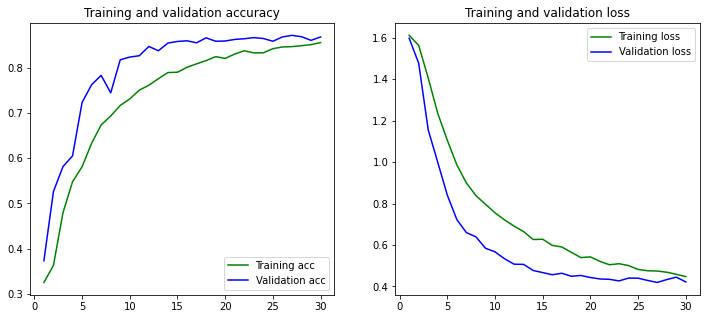

In [27]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
PlotGraph(history)

In [28]:
model.load_weights(checkpoint_filepath)


In [29]:
predict = model.predict(TEST)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class


array([4, 4, 4, ..., 2, 2, 5])

Text(69.0, 0.5, 'Predicted Class')

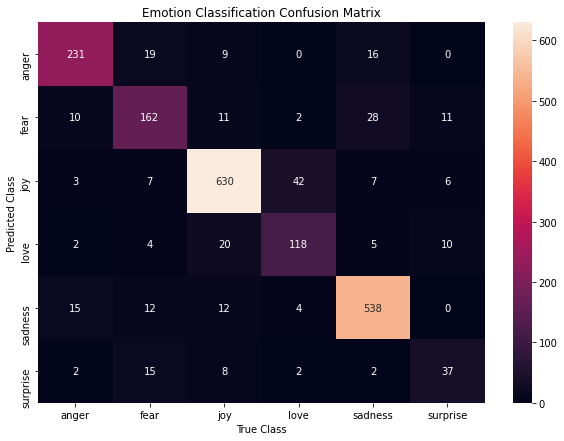

In [30]:
cm = confusion_matrix(test_df["encoded_test_label"], predict_class)
df_cm = pd.DataFrame(cm, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")
plt.title('Emotion Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [31]:
from sklearn.metrics import classification_report

print(classification_report(test_df["encoded_test_label"], predict_class, target_names =["anger", "fear", "joy", "love", "sadness", "surprise"]))


print("Accuracy:", accuracy_score(test_df["encoded_test_label"], predict_class))

print("Recall:", recall_score(test_df["encoded_test_label"], predict_class, average='weighted'))

print("Precision:", precision_score(test_df["encoded_test_label"], predict_class, average='weighted'))

print("F1-score:", f1_score(test_df["encoded_test_label"], predict_class, average='weighted'))


              precision    recall  f1-score   support

       anger       0.88      0.84      0.86       275
        fear       0.74      0.72      0.73       224
         joy       0.91      0.91      0.91       695
        love       0.70      0.74      0.72       159
     sadness       0.90      0.93      0.91       581
    surprise       0.58      0.56      0.57        66

    accuracy                           0.86      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.86      0.86      0.86      2000

Accuracy: 0.858
Recall: 0.858
Precision: 0.8580491622274294
F1-score: 0.8578601683798179


In [32]:
tf.keras.backend.clear_session()

<h2>Multinominal NB</h2>

In [33]:
mnb = MultinomialNB()
x_train = cv.fit_transform(train_df['text_prep'])
x_test = cv.transform(test_df['text_prep'])
y_train_2 = train_df['encoded_train_label']
y_test_2 = test_df['encoded_test_label']


mnb.fit(x_train, y_train_2)

# make prediction on testing data

y_pred_test_mnb = mnb.predict(x_test)
y_predprob_mnb = mnb.predict_proba(x_test)



Text(69.0, 0.5, 'Predicted Class')

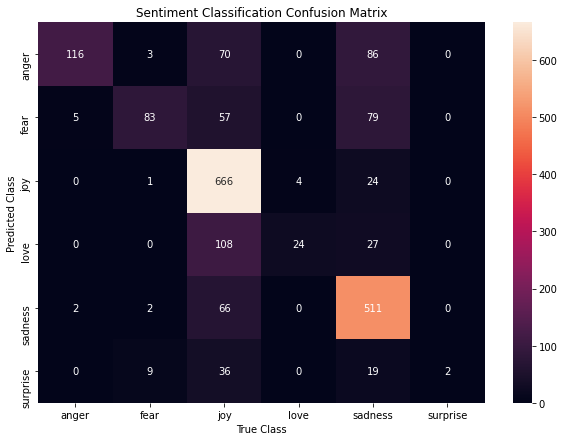

In [34]:
matrix_mnb_2 = confusion_matrix(y_test_2, y_pred_test_mnb)
df_cm_mnb_2 = pd.DataFrame(matrix_mnb_2, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_mnb_2,annot=True, fmt ="d")
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [35]:
print(classification_report(y_test_2, y_pred_test_mnb,target_names = ["anger", "fear", "joy", "love", "sadness", "surprise"])
)

print("Accuracy:", accuracy_score(y_test_2, y_pred_test_mnb))

print("Recall:", recall_score(y_test_2, y_pred_test_mnb, average='weighted'))

print("Precision:", precision_score(y_test_2, y_pred_test_mnb,average='weighted'))

print("F1-score:", f1_score(y_test_2, y_pred_test_mnb, average='weighted'))

              precision    recall  f1-score   support

       anger       0.94      0.42      0.58       275
        fear       0.85      0.37      0.52       224
         joy       0.66      0.96      0.78       695
        love       0.86      0.15      0.26       159
     sadness       0.68      0.88      0.77       581
    surprise       1.00      0.03      0.06        66

    accuracy                           0.70      2000
   macro avg       0.83      0.47      0.49      2000
weighted avg       0.76      0.70      0.66      2000

Accuracy: 0.701
Recall: 0.701
Precision: 0.755406174331036
F1-score: 0.6565656230489492


<h2>Logistic Regression</h2>

In [36]:
x_train = cv.fit_transform(train_df['text_prep'])
y_train = train_df['encoded_train_label']
x_test = cv.transform(test_df['text_prep'])
y_test = test_df['encoded_test_label']

# fit a logistic regression classifier on the training data use default settings
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(x_train, y_train)

# make prediction on testing data
y_pred_test_lr = lr.predict(x_test)
y_predprob_lr = lr.predict_proba(x_test)



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(69.0, 0.5, 'Predicted Class')

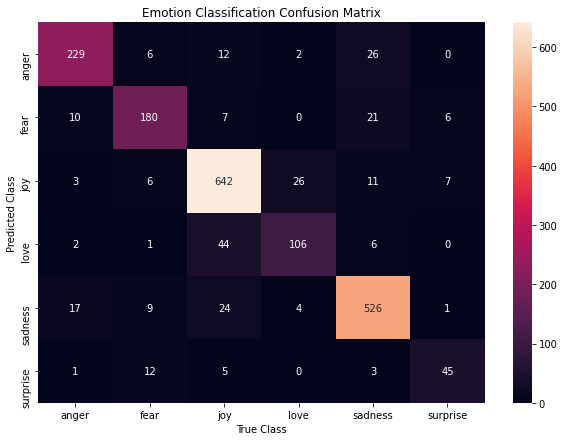

In [37]:
matrix_lr = confusion_matrix(y_test,y_pred_test_lr)
df_cm_lr = pd.DataFrame(matrix_lr, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_lr,annot=True, fmt ="d")
plt.title('Emotion Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

In [38]:
print(classification_report(y_test, y_pred_test_lr, target_names = ["anger", "fear", "joy", "love", "sadness", "surprise"]))

print("Accuracy:", accuracy_score(y_test,y_pred_test_lr))

print("Recall:", recall_score(y_test,y_pred_test_lr, average="weighted"))

print("Precision:", precision_score(y_test,y_pred_test_lr, average="weighted"))

print("F1-score:", f1_score(y_test,y_pred_test_lr, average="weighted"))


              precision    recall  f1-score   support

       anger       0.87      0.83      0.85       275
        fear       0.84      0.80      0.82       224
         joy       0.87      0.92      0.90       695
        love       0.77      0.67      0.71       159
     sadness       0.89      0.91      0.90       581
    surprise       0.76      0.68      0.72        66

    accuracy                           0.86      2000
   macro avg       0.83      0.80      0.82      2000
weighted avg       0.86      0.86      0.86      2000

Accuracy: 0.864
Recall: 0.864
Precision: 0.8622436647302659
F1-score: 0.8623852329737672


<h1>SVM</h1>

In [39]:
x_train = cv.fit_transform(train_df['text_prep'])
x_test = cv.transform(test_df['text_prep'])
y_train_2 = train_df['encoded_train_label']
y_test_2 = test_df['encoded_test_label']

classifier_linear_2 = svm.SVC(kernel='linear')

classifier_linear_2.fit(x_train, y_train_2)

prediction_linear_2 = classifier_linear_2.predict(x_test)


# results
report_2 = classification_report(y_test_2, prediction_linear_2,target_names =["anger", "fear", "joy", "love", "sadness", "surprise"])
matrix_svm_2 = confusion_matrix(y_test_2,prediction_linear_2)


Text(69.0, 0.5, 'Predicted Class')

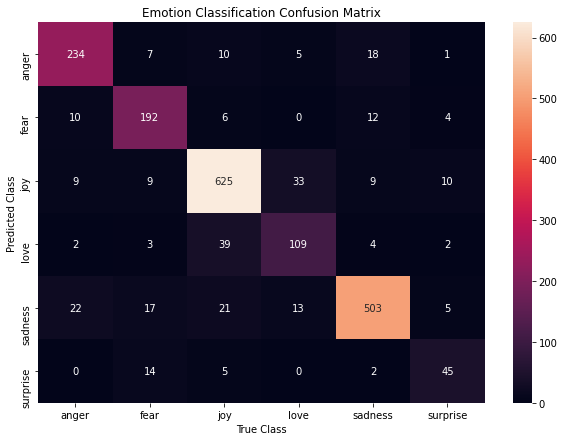

In [40]:
df_cm_svm_2 = pd.DataFrame(matrix_svm_2, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_svm_2,annot=True, fmt ="d")
plt.title('Emotion Classification Confusion Matrix')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')


In [41]:
print(report_2)

print("Accuracy:", accuracy_score(y_test_2, prediction_linear_2))

print("Recall:", recall_score(y_test_2, prediction_linear_2, average='weighted'))

print("Precision:", precision_score(y_test_2, prediction_linear_2, average='weighted'))

print("F1-score:", f1_score(y_test_2, prediction_linear_2, average='weighted'))


              precision    recall  f1-score   support

       anger       0.84      0.85      0.85       275
        fear       0.79      0.86      0.82       224
         joy       0.89      0.90      0.89       695
        love       0.68      0.69      0.68       159
     sadness       0.92      0.87      0.89       581
    surprise       0.67      0.68      0.68        66

    accuracy                           0.85      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.86      0.85      0.85      2000

Accuracy: 0.854
Recall: 0.854
Precision: 0.8556143857164777
F1-score: 0.8544255043030531
